<a href="https://colab.research.google.com/github/Swetaa23/546_project/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Mount Drive and Import

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load Data

In [5]:
customers_df = pd.read_csv("/content/drive/My Drive/MGTE/4B/546/customers.csv")
articles_df = pd.read_csv("/content/drive/My Drive/MGTE/4B/546/articles.csv")
transactions_df = pd.read_csv("/content/drive/My Drive/MGTE/4B/546/Transactions Train.csv")

print("Customers:", customers_df.shape)
print("Articles:", articles_df.shape)
print("Transactions:", transactions_df.shape)


Customers: (1371980, 7)
Articles: (105542, 25)
Transactions: (31788324, 5)


#### Merge Data

In [6]:
merged_df = transactions_df.merge(articles_df, on="article_id", how="left")
merged_df = merged_df.merge(customers_df, on="customer_id", how="left")
print("Merged DataFrame columns:", merged_df.columns)


Merged DataFrame columns: Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')


#### Filter Top Categories & Encode Target

In [7]:
# identify most common product groups
print("Product Group counts:")
print(merged_df["product_group_name"].value_counts())

# Keep only the 9 most frequent product groups
top_categories = merged_df["product_group_name"].value_counts().index[:9]
merged_df = merged_df[merged_df["product_group_name"].isin(top_categories)].copy()

# label encode the target variable (product_group_name)
label_encoder = LabelEncoder()
merged_df["target"] = label_encoder.fit_transform(merged_df["product_group_name"])
print("Category mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Product Group counts:
product_group_name
Garment Upper body       12552755
Garment Lower body        7046054
Garment Full body         3552470
Swimwear                  2579222
Underwear                 2565858
Accessories               1599593
Shoes                      745521
Socks & Tights             685712
Nightwear                  348180
Unknown                     97040
Bags                         7313
Items                        5427
Cosmetic                     1500
Underwear/nightwear           559
Furniture                     533
Garment and Shoe care         279
Stationery                    229
Interior textile               74
Fun                             5
Name: count, dtype: int64
Category mapping: {'Accessories': 0, 'Garment Full body': 1, 'Garment Lower body': 2, 'Garment Upper body': 3, 'Nightwear': 4, 'Shoes': 5, 'Socks & Tights': 6, 'Swimwear': 7, 'Underwear': 8}


#### Data Processing & Feature Engineering

In [8]:
# One hot encode customer categorical features
categorical_cols = ["club_member_status", "fashion_news_frequency", "sales_channel_id"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_features = encoder.fit_transform(merged_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Total customer purchases
customer_total_purchases = merged_df.groupby("customer_id")["article_id"].count().reset_index()
customer_total_purchases.rename(columns={"article_id": "total_purchases"}, inplace=True)
merged_df = merged_df.merge(customer_total_purchases, on="customer_id", how="left")

# Days since last purchase
merged_df["t_dat"] = pd.to_datetime(merged_df["t_dat"])
last_purchase = merged_df.groupby("customer_id")["t_dat"].max().reset_index()
last_purchase["days_since_last_purchase"] = (merged_df["t_dat"].max() - last_purchase["t_dat"]).dt.days
merged_df = merged_df.merge(last_purchase[["customer_id", "days_since_last_purchase"]], on="customer_id", how="left")

# Customer purchases by category
customer_category_counts = merged_df.groupby(["customer_id", "product_group_name"])["article_id"].count().reset_index()
customer_category_counts.rename(columns={"article_id": "purchase_count"}, inplace=True)
customer_purchase_history = customer_category_counts.pivot(index="customer_id", columns="product_group_name", values="purchase_count").fillna(0)
merged_df = merged_df.merge(customer_purchase_history, on="customer_id", how="left")

# Fill numerical n/a's
merged_df["age"].fillna(merged_df["age"].median(), inplace=True)
merged_df["price"].fillna(merged_df["price"].median(), inplace=True)
merged_df["total_purchases"].fillna(0, inplace=True)
merged_df["days_since_last_purchase"].fillna(merged_df["days_since_last_purchase"].median(), inplace=True)

# Add encoded categorical features
merged_df = pd.concat([merged_df, encoded_df], axis=1)


<ipython-input-8-86ecc476820d>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["age"].fillna(merged_df["age"].median(), inplace=True)
<ipython-input-8-86ecc476820d>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

#### Prep Final Training Data

In [9]:
# features for modeling
selected_features = ["price", "age", "total_purchases", "days_since_last_purchase"]
selected_features += encoded_df.columns.tolist()  # Add one-hot features
selected_features += customer_purchase_history.columns.tolist()  # Add category purchase counts

X = merged_df[selected_features]
y = merged_df["target"]

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


Build Multilayer Perceptron

In [10]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# output classes
num_classes = len(np.unique(y_train))

# model arch
inputs = Input(shape=(X_train.shape[1],), name="input_layer")
x = Dense(128, activation="relu")(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax")(x)

# Build & compile
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,601 (57.04 KB)

 Trainable params: 14,153 (55.29 KB)

 Non-trainable params: 448 (1.75 KB)

#### Train

In [19]:
# callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/5
79189/79189 ━━━━━━━━━━━━━━━━━━━━ 367s 5ms/step - accuracy: 0.4745 - loss: 1.3589 - val_accuracy: 0.5052 - val_loss: 1.2414 - learning_rate: 0.0010
Epoch 2/5
79189/79189 ━━━━━━━━━━━━━━━━━━━━ 359s 5ms/step - accuracy: 0.4904 - loss: 1.2913 - val_accuracy: 0.5059 - val_loss: 1.2378 - learning_rate: 0.0010
Epoch 3/5
79189/79189 ━━━━━━━━━━━━━━━━━━━━ 359s 5ms/step - accuracy: 0.4917 - loss: 1.2856 - val_accuracy: 0.5055 - val_loss: 1.2358 - learning_rate: 0.0010
Epoch 4/5
79189/79189 ━━━━━━━━━━━━━━━━━━━━ 357s 4ms/step - accuracy: 0.4927 - loss: 1.2826 - val_accuracy: 0.5062 - val_loss: 1.2336 - learning_rate: 0.0010
Epoch 5/5
79189/79189 ━━━━━━━━━━━━━━━━━━━━ 350s 4ms/step - accuracy: 0.4925 - loss: 1.2811 - val_accuracy: 0.5060 - val_loss: 1.2319 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


#### Evaluate

In [20]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Generate predictions & print report
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

197972/197972 ━━━━━━━━━━━━━━━━━━━━ 276s 1ms/step - accuracy: 0.5059 - loss: 1.2316

Test Accuracy: 50.59%
197972/197972 ━━━━━━━━━━━━━━━━━━━━ 180s 909us/step

Classification Report:
              precision    recall  f1-score   support

           0     0.5137    0.2035    0.2915    319919
           1     0.4780    0.2761    0.3500    710494
           2     0.5200    0.3615    0.4265   1409211
           3     0.4983    0.8189    0.6196   2510551
           4     0.7277    0.0512    0.0956     69636
           5     0.5650    0.0750    0.1325    149104
           6     0.5624    0.2620    0.3574    137142
           7     0.5588    0.3867    0.4571    515844
           8     0.5190    0.2494    0.3369    513172

    accuracy                         0.5059   6335073
   macro avg     0.5492    0.2982    0.3408   6335073
weighted avg     0.5137    0.5059    0.4708   6335073



#### Plot

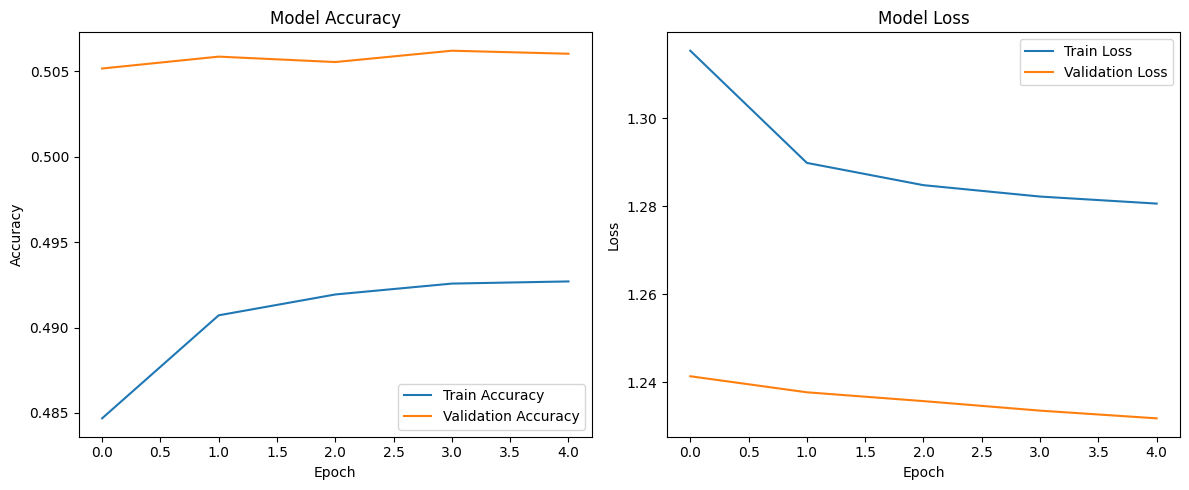

In [21]:
# training & validation accuracy & loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()